In [4]:
import torch
from MonotonicNetwork import MonotonicNetwork
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

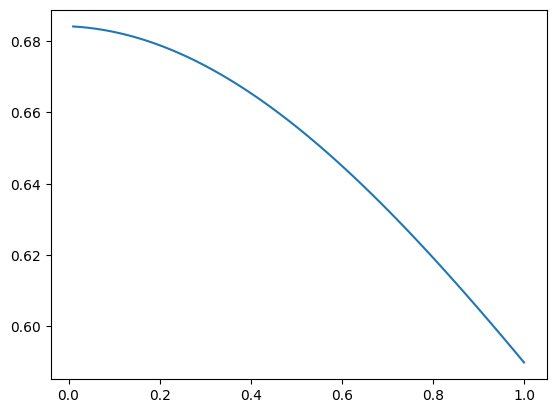

In [5]:
network = MonotonicNetwork(2, 32, 1)

t = torch.ones((100,1))
s = torch.linspace(0, 1, 100).unsqueeze(1)

inputs = torch.cat([t, s], dim=1).float()

outputs = network(inputs)

plt.plot(s.detach().numpy(), (outputs / inputs[:, 1:]).squeeze().detach().numpy())
plt.show()

In [12]:
def train(model, inputs, targets, epochs=500, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()  # 目标损失函数（可以根据需要更改）

    for epoch in range(epochs):
        model.train()
        
        optimizer.zero_grad()
        
        # 正常的前向传播
        outputs, monotonic_loss = model.output_and_monotonicity_loss(inputs)
        
        # 计算标准的损失
        loss = criterion(outputs, targets)        
        
        # 总损失 = 传统损失 + 单调性损失
        total_loss = loss + monotonic_loss * torch.tensor(1e3)
        
        # 反向传播
        total_loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {total_loss.item()}')
            
    return model

In [11]:
def gen_pretrain_data(n=252, T=1):
    t = np.linspace(0, T, T*n+1)

    tj_1 = np.tile(t[:-1], T*n).reshape(T*n, T*n)  # Times tj excluding the final point
    ti_1 = tj_1.T  # Transpose to create a grid of ti values
    tj = np.tile(t[1:], T*n).reshape(T*n, T*n)  # Times tj excluding the initial point

    alpha = 0.279+0.5 ## H=0.279

    mask = tj <= ti_1
    KK = np.zeros((T*n,T*n))
    KK[mask] = (ti_1 ** alpha - (ti_1 - tj) ** alpha)[mask] / gamma(1 + alpha)

    t_train = ti_1[mask].reshape(-1,1)
    s_train = tj[mask].reshape(-1,1)

    inputs = np.concatenate([t_train, s_train], axis=1)
    inputs = torch.tensor(inputs, dtype=torch.float32)
    outputs = KK[mask].reshape(-1,1)
    outputs = torch.tensor(outputs, dtype=torch.float32)

    return inputs, outputs

In [13]:
input_dim = 2  # 输入维度
hidden_dim = 32  # 隐藏层大小
output_dim = 1  # 输出维度

# 创建模型
model = MonotonicNetwork(input_dim, hidden_dim, output_dim)

inputs, targets = gen_pretrain_data(252, 6)
print(f"input shape: {inputs.shape}, target shape: {targets.shape}")

input shape: torch.Size([1142316, 2]), target shape: torch.Size([1142316, 1])


C:\Users\31251\AppData\Local\Temp\ipykernel_14484\515633575.py:12: RuntimeWarning: invalid value encountered in power
  KK[mask] = (ti_1 ** alpha - (ti_1 - tj) ** alpha)[mask] / gamma(1 + alpha)


In [ ]:
trained_model = train(model, inputs, targets, epochs=500, lr=0.01)

In [16]:
torch.save(trained_model.state_dict(), 'pretrain_network.pth')

In [14]:
trained_model = MonotonicNetwork(2,32,1)
trained_model.load_state_dict(torch.load('pretrain_network.pth', weights_only=False))
trained_model.eval()

MonotonicNetwork(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc21): Linear(in_features=32, out_features=32, bias=True)
  (fc22): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [15]:
print(type(trained_model))

train(trained_model, inputs, targets, epochs=500, lr=0.01)

<class 'MonotonicNetwork.MonotonicNetwork'>
Epoch 0/500, Loss: 0.015326063148677349
Epoch 10/500, Loss: 0.030981985852122307
Epoch 20/500, Loss: 0.020202528685331345
Epoch 30/500, Loss: 0.012593824416399002
Epoch 40/500, Loss: 0.010550640523433685
Epoch 50/500, Loss: 0.008976687677204609
Epoch 60/500, Loss: 0.007643937598913908
Epoch 70/500, Loss: 0.006543861702084541
Epoch 80/500, Loss: 0.005568709224462509
Epoch 90/500, Loss: 0.00477279257029295
Epoch 100/500, Loss: 0.004112226888537407
Epoch 110/500, Loss: 0.0035643531009554863
Epoch 120/500, Loss: 0.0031052948907017708
Epoch 130/500, Loss: 0.002719135722145438
Epoch 140/500, Loss: 0.002392726019024849
Epoch 150/500, Loss: 0.0021152887493371964
Epoch 160/500, Loss: 0.0018781956750899553
Epoch 170/500, Loss: 0.0016745260218158364
Epoch 180/500, Loss: 0.0014987490139901638
Epoch 190/500, Loss: 0.0013463734649121761
Epoch 200/500, Loss: 0.0012137691956013441
Epoch 210/500, Loss: 0.001097968895919621
Epoch 220/500, Loss: 0.0009965236531

MonotonicNetwork(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc21): Linear(in_features=32, out_features=32, bias=True)
  (fc22): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

C:\Users\31251\AppData\Local\Temp\ipykernel_14484\1355054083.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  target_test = (t_test ** alpha - (t_test - s_test) ** alpha) / gamma(1 + alpha)


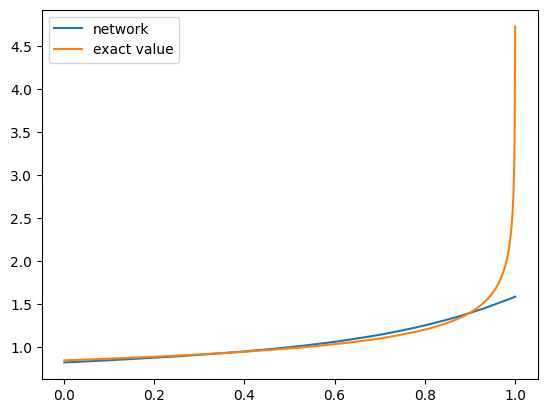

In [18]:
t_test = torch.ones(800,1)
s_test = torch.linspace(0, 1, 800).unsqueeze(1)

dt = s_test[1] - s_test[0]

input_test= torch.cat([t_test, s_test], dim=1).float()
output_test = trained_model(input_test) 
alpha = torch.tensor(0.279+0.5)
target_test = (t_test ** alpha - (t_test - s_test) ** alpha) / gamma(1 + alpha)

output_kernal = (output_test[1:] - output_test[:-1]) / dt
target_kernal = (target_test[1:] - target_test[:-1]) / dt
# plt.plot(s_test.detach().numpy(), output_test.detach().numpy(), label='network')
# plt.plot(s_test.detach().numpy(), target_test.detach().numpy(), label='exact value')
plt.plot(s_test[1:].detach().numpy(), output_kernal.detach().numpy(), label='network')
plt.plot(s_test[1:].detach().numpy(), target_kernal.detach().numpy(), label='exact value')
plt.legend()
plt.show()

In [ ]:
def train(model, inputs, targets, epochs=500, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()  # 目标损失函数（可以根据需要更改）

    for epoch in range(epochs):
        model.train()
        
        optimizer.zero_grad()
        
        # 正常的前向传播
        outputs, monotonic_loss = model.output_and_monotonicity_loss(inputs)
        
        # 计算标准的损失
        loss = criterion(outputs, targets)        
        
        # 总损失 = 传统损失 + 单调性损失
        total_loss = loss + monotonic_loss * torch.tensor(1e3)
        
        # 反向传播
        total_loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{epochs}, Loss: {total_loss.item()}')
            
    return model

In [ ]:
def gen_pretrain_data(n=252, T=1):
    t = np.linspace(0, T, T*n+1)

    tj_1 = np.tile(t[:-1], T*n).reshape(T*n, T*n)  # Times tj excluding the final point
    ti_1 = tj_1.T  # Transpose to create a grid of ti values
    tj = np.tile(t[1:], T*n).reshape(T*n, T*n)  # Times tj excluding the initial point

    alpha = 0.279+0.5 ## H=0.279

    mask = tj <= ti_1
    KK = np.zeros((T*n,T*n))
    KK[mask] = (ti_1 ** alpha - (ti_1 - tj) ** alpha)[mask] / gamma(1 + alpha)

    t_train = ti_1[mask].reshape(-1,1)
    s_train = tj[mask].reshape(-1,1)

    inputs = np.concatenate([t_train, s_train], axis=1)
    inputs = torch.tensor(inputs, dtype=torch.float32)
    outputs = KK[mask].reshape(-1,1)
    outputs = torch.tensor(outputs, dtype=torch.float32)

    return inputs, outputs

In [ ]:
if __name__ == "__main__":
    input_dim = 2  # 输入维度
    hidden_dim = 32  # 隐藏层大小
    output_dim = 1  # 输出维度

    # 创建模型
    model = MonotonicNetwork(input_dim, hidden_dim, output_dim)

    inputs, targets = gen_pretrain_data(252, 6)
    print(f"input shape: {inputs.shape}, target shape: {targets.shape}")
    
    trained_model = train(model, inputs, targets, epochs=500, lr=0.01)

C:\Users\31251\AppData\Local\Temp\ipykernel_28832\515633575.py:12: RuntimeWarning: invalid value encountered in power
  KK[mask] = (ti_1 ** alpha - (ti_1 - tj) ** alpha)[mask] / gamma(1 + alpha)


input shape: torch.Size([1142316, 2]), target shape: torch.Size([1142316, 1])
Epoch 0/500, Loss: 0.9786930680274963
Epoch 10/500, Loss: 0.8441652059555054
Epoch 20/500, Loss: 0.7384952902793884
Epoch 30/500, Loss: 0.6491082310676575
Epoch 40/500, Loss: 0.5710719227790833
Epoch 50/500, Loss: 0.5033155679702759
Epoch 60/500, Loss: 0.44488030672073364
Epoch 70/500, Loss: 0.3942178785800934
Epoch 80/500, Loss: 0.3503314256668091
Epoch 90/500, Loss: 0.3123762905597687
Epoch 100/500, Loss: 0.279392808675766
Epoch 110/500, Loss: 0.25068342685699463
Epoch 120/500, Loss: 0.22551260888576508
Epoch 130/500, Loss: 0.20389313995838165
Epoch 140/500, Loss: 0.18410147726535797
Epoch 150/500, Loss: 0.16697372496128082
Epoch 160/500, Loss: 0.15216343104839325
Epoch 170/500, Loss: 0.13827724754810333
Epoch 180/500, Loss: 0.12619751691818237
Epoch 190/500, Loss: 0.11557074636220932
Epoch 200/500, Loss: 0.10635896772146225
Epoch 210/500, Loss: 0.09746379405260086
Epoch 220/500, Loss: 0.08994759619235992
E

In [ ]:
torch.save(trained_model.state_dict(), 'pretrain_network.pth')

In [2]:
load_model = MonotonicNetwork(2,32,1)
load_model.load_state_dict(torch.load('pretrain_network.pth', weights_only=False))
load_model.eval()

MonotonicNetwork(
  (fc1): Linear(in_features=2, out_features=32, bias=True)
  (fc21): Linear(in_features=32, out_features=32, bias=True)
  (fc22): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
print(type(load_model))

train(load_model, inputs, targets, epochs=500, lr=0.01)

In [3]:
t_test = torch.ones(800,1)*2
s_test = torch.linspace(0, 2, 800).unsqueeze(1)

dt = s_test[1] - s_test[0]

input_test= torch.cat([t_test, s_test], dim=1).float()
output_test = load_model(input_test) 
alpha = torch.tensor(0.279+0.5)
target_test = (t_test ** alpha - (t_test - s_test) ** alpha) / gamma(1 + alpha)

output_kernal = (output_test[1:] - output_test[:-1]) / dt
target_kernal = (target_test[1:] - target_test[:-1]) / dt
plt.plot(s_test[:-1].detach().numpy(), output_kernal.detach().numpy(), label='network')
plt.plot(s_test[:-1].detach().numpy(), target_kernal.detach().numpy(), label='exact value')
plt.legend()
plt.show()

NameError: name 'gamma' is not defined